<a href="https://colab.research.google.com/github/lmoghimi/personal-processing/blob/main/beamline_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Run these first**

In [ ]:
#@title Imports for JupyterLite
%pip install -q ipywidgets

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import heapq

import pandas as pd
import csv

from scipy.signal import find_peaks

# timestamps = ['primary-1', ]
shift = True            #
get_timestamps = True
#ntimestamps = 2 #for comparison between t0 and tf
ntimestamps = 125 #for all runs
#ntimestamps_depths
lw = 0.75 #linewidth
userdir = "/content/drive/Shareddrives/leoradm_group/NSLS-II_202403"
scriptdir = os.path.join(userdir, 'userScripts')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Peak positions for reference
wavelength = 0.1824 #angstrom
'''
ref_tth_fe = [5.205, 9.022, 7.364, 10.421, 11.656, 12.772, 13.801, 14.759] #2theta
ref_d_fe = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_fe,2))) #conversion to d
ref_q_fe = 2*np.pi/ref_d_fe #conversion to q
'''
#ref_q_fe = [3.128, 5.419, 4.424, 6.995, 8.277, 6.257, 7.663]
#ref_q_fe = [3.128, 5.419, 4.424]
ref_q_fe = [3.128] #prominent isolated phase peak
#lincol_fe='tab:green' #iron
lincol_fe='tab:brown'

'''
ref_tth_w = [4.833, 6.837, 4.185, 8.019, 10.820, 8.376, 11.856, 10.545] #remove 3rd number if plot in tth
ref_d_w = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_w,2)))
ref_q_w = 2*np.pi/ref_d_w
'''
#ref_q_w = [2.905, 4.108, 2.516, 4.817, 6.495, 5.031, 7.115, 6.331, 8.715, 8.593, 7.547, 8.216, 5.810]
#ref_q_w = [2.905, 4.108, 2.516]
ref_q_w = [4.108] #prominent isolated phase peak
#lincol_w='tab:red' #wustite
lincol_w='tab:pink'

'''
ref_tth_m = [4.145, 7.083, 6.520, 3.540, 9.639, 5.019, 6.143, 8.324, 10.846] #remove 1st one if plot in tth
ref_d_m = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_m,2)))
ref_q_m = 2*np.pi/ref_d_m
'''
#ref_q_m = [2.4783, 2.5973, 4.2458, 3.8889, 2.1214, 2.9982, 5.7584, 3.6680, 1.2887, 4.9086]
#ref_q_m = [2.4783, 2.5973, 4.2458]
ref_q_m = [2.1214] #prominent isolated phase peak
#lincol_m='tab:purple' #magnetite
lincol_m='tab:green'

'''
ref_tth_h = [3.870, 4.150, 6.167, 5.675, 7.033, 7.190, 2.837, 7.973] #remove 2nd number if plot in tth
ref_d_h = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_h,2)))
ref_q_h = 2*np.pi/ref_d_h
'''
#ref_q_h = [2.4985, 2.3135, 3.7118, 4.3288, 3.41365, 4.2259, 1.6965, 2.8481, 4.8017, 3.92775, 4.9868, 5.6860, 5.5009, 5.9533, 6.5394]
#ref_q_h = [2.4985, 2.3135, 3.7118]
ref_q_h = [2.3135] #prominent isolated phase peak
#lincol_h='tab:orange' #hematite
lincol_h='tab:cyan'

#ref_q_ceo2 = [2.013, 2.324, 3.287, 3.854, 4.025, 4.648, 5.065, 5.197, 5.693, 6.038]
ref_q_ceo2 = [2.013]
lincol_ceo2 = 'tab:orange'

lincol_h_ore = 'tab:purple'

lincol_magh='tab:olive' #maghemite

lincol_qz = 'tab:gray' #quartz

#lincol_wf = 'tab:blue' #sets the line color for the waterfall series
#lincol_wf = 'navy'

In [ ]:
#@title Plot inputs for summary figs
#inputs:
#DAQ's t=0, in-situ series parameters, pyrometer, laser/PS, index of power supply that corresponds to DAQ's t=0
####################### inputs ###################################
#input farther down the run # --> run60
t_xrd_start = '23:04:56'
frame_length = 1.2
fn_pyrom = 'sample_66_20240328_230734'
fn_laser = 'LOG-Mar.28.2024-11.08.12-run64'
t_laser_log_start = '11:04:51'
t_laser_sampling = 1
index_start = 5 #5 sec difference → 5 sec / 1 sec/rec → rec:5

ntimestamps = 125 ##########for phase vs time

#range and prominence for peak finding for run#
I_fe_low, I_fe_up, prominence_fe = 880, 915, .075
I_w_low, I_w_up, prominence_w = 1165, 1202, .05
I_m_low, I_m_up, prominence_m = 590, 625, .05
I_h_low, I_h_up, prominence_h = 660, 685, .05
I_ceo2_low, I_ceo2_up, prominence_ceo2 = 550, 590, .3

response = "n"
markersz = 2
lw = 2

# **Use this to check the findpeaks performance.**
*modify peak range and/or prominence as needed*

In [ ]:
#@title Loading data files (1/2)
for run in ['run26']:
    ntimestamps = 15 ##########change later
    print('run# = ', run)

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    raw_data_save_all = []

    print('ntimestamps =', ntimestamps)
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        '''
        print()
        print('Loading file', filename)
        '''
        ##print('Scan # ', timestamp_num)
        rawdata = np.loadtxt(filename) #each rawdata is [(#data, 2)], where 2 represents q and I columns
        raw_data_save_all.append(rawdata)
        '''
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        '''
    ##### convert raw data_save_all into numpy array ######
    raw_data_save_all = np.array(raw_data_save_all) #stacks the array  #makes 3D array of 125, q and I for each run --> (nstimestamps, nt, 2)
    print('shape of array is = ', raw_data_save_all.shape)

#laser = [5, 30, 105] #run64 #at what 3 scan numbers does the laser turn on, reach max power, and turn off?
#laser = [7, 32, 107] #run51
#laser = [4, 29, 104] #run52
#laser = [6, 31, 106] #run53
#laser = [3, 28, 103] #run54
#laser = [5, 30, 105] #run 56
#laser = [0, 25, 100] #run60
#laser = [7, 32, 107] #run62
#laser = [4, 29, 104] #run65

run# =  run26
ntimestamps = 15
shape of array is =  (15, 3000, 2)


This is the first file


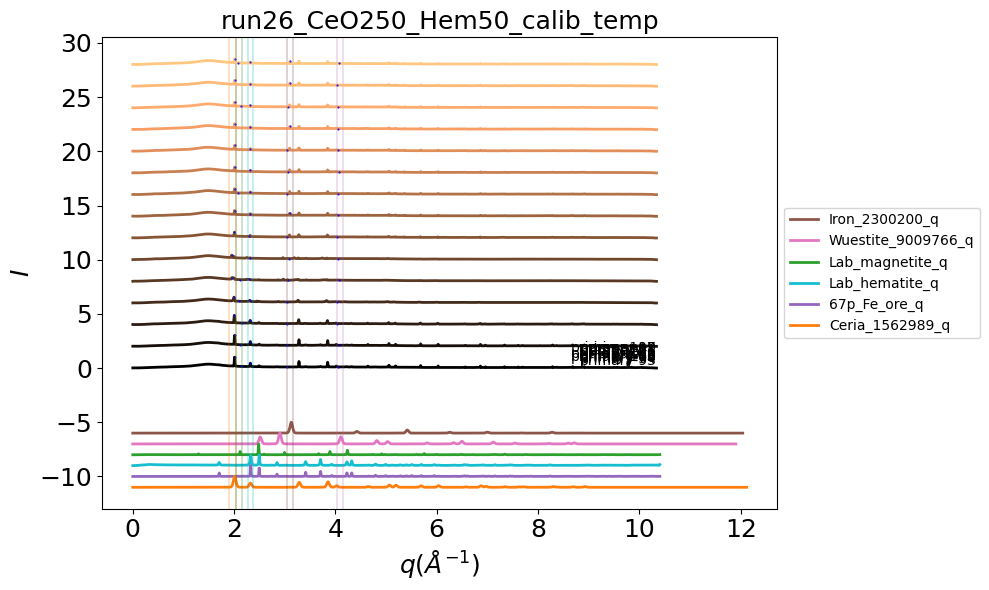

In [ ]:
#@title Plotting findpeaks results (2/2)

## create figure object -- plotting setting ##
#figsize = (12, 6)
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax.set_ylabel(r'$I$', fontsize=fs)
ax.set_title(expname, fontsize=fs)
ax.tick_params(labelsize=fs)

##plot display for markers and reference lines
lw_fp = 0.025 #linewidth for find_peaks range
markersz = .5 #define marker size for results of find_peaks
#markersh = 'x' #define marker shape
markersh = 'o'
marcol_fe = 'b'
marcol_h = 'b'
marcol_w = 'b'
marcol_m = 'b'
mark_dist = 0 #marker vertical distance from peak

######### load multiple reference files, Yifan, 2024/4/12
#ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
#color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q','Ceria_1562989_q']
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore, lincol_ceo2]
ref_shift_y = -1
for i_phase, ref_phase in enumerate(ref_phases):
    reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
    refdata = np.loadtxt(reffile)
    q_ref = refdata[:, 0]
    I_ref = refdata[:, 1]
    I_ref = I_ref - I_ref.min() #"baselining" the data
    I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) -5
    ax.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])

## here we want to define 8 sets of inputs: 4 scrollbars to define the range for each phase peak, 4 inputs for the prominence of each phase peak


################# plotting setting #####################################################################################
# figsize = (10, 6)
# fs = 18
# fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!
# ax.clear()

################ plotting selected timestamps and finding peaks ########################################################
num_of_lines = len(timestamps)
lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
counting = 0
find_peak_outputs = []
for iv, timestamp in enumerate(timestamps):
    #print(iv)
    timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
    filename = filedict[timestamp]
    rawdata = raw_data_save_all[iv, :, :]
    q = rawdata[:, 0]
    I = rawdata[:, 1]
    I = I - I.min() #"baselining" the data

    if timestamp == 'primary-1':
      print('This is the first file')
      #I0 = I
      I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
      I_treated = I0/I0.max()
    # '''
    # if timestamp == 'primary-1': #for run 52, need to have 125 files
    #   print('This is the first file')
    #   I_treated = I/I.max()
    # elif timestamp == 'primary-2': #for run 52, need to have 125 files
    #   print('This is the second file')
    #   #I0 = I
    #   I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
    #   I_treated = I0/I0.max()
    # '''
    else:
      #print('not the first file...')
      #I_treated = I/I0
      I_treated = I/I0.max()
      #I = I + iv * 5 #only for visualizing, not for peak finding

    ###### plot waterfall data ########################################
    c=next(lincol_gradient)
    #ax.plot(q, I, color = c, linewidth = lw)
    wf_shift = iv*2
    '''
    if iv == laser[0] or iv == laser[1] or iv == laser[2]: #condition for whether this is a scan when something important happens with the laser
        ax.plot(q, I_treated + wf_shift, color = 'r', linewidth = lw)
    else:
        ax.plot(q, I_treated + wf_shift, color = c, linewidth = lw) #here, Lauren!
    '''
    ax.plot(q, I_treated + wf_shift, color = c, linewidth = lw)
    ax.text(q[-1], I[-1], timestamp, ha='right', va='bottom')

    counting = counting + 1

    ####### find peaks ######################################################

    #see where the peak range should be, for given input index
    ax.axvline(x=q[I_fe_low], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
    ax.axvline(x=q[I_fe_up], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
    ax.axvline(x=q[I_w_low], linestyle='solid', linewidth = lw_fp, color=lincol_w)
    ax.axvline(x=q[I_w_up], linestyle='solid', linewidth = lw_fp, color=lincol_w)
    ax.axvline(x=q[I_m_low], linestyle='solid', linewidth = lw_fp, color=lincol_m)
    ax.axvline(x=q[I_m_up], linestyle='solid', linewidth = lw_fp, color=lincol_m)
    ax.axvline(x=q[I_h_low], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    ax.axvline(x=q[I_h_up], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    ax.axvline(x=q[I_ceo2_low], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)
    ax.axvline(x=q[I_ceo2_up], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)

    #ax.axhline(y=prominence_fe, linestyle='solid', linewidth = .1, color=lincol_fe)
    ##ax.axhline(y=prominence_w, linestyle='solid', linewidth = .1, color=lincol_w)
    ##ax.axhline(y=prominence_m, linestyle='solid', linewidth = .1, color=lincol_m)
    ##ax.axhline(y=prominence_h, linestyle='solid', linewidth = .1, color=lincol_h)

    I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
    I_w = I_treated[I_w_low:I_w_up]
    I_m = I_treated[I_m_low:I_m_up]
    I_h = I_treated[I_h_low:I_h_up]
    I_ceo2 = I_treated[I_ceo2_low:I_ceo2_up]

    #num_phases = ['fe', 'w', 'm', 'h']
    num_phases = ['fe', 'w', 'm', 'h', 'ceo2']
    for iii in num_phases: #repeat this process for each phase
      #print('iii = ', iii)
      ############for iron#############################
      if iii == num_phases[0]: #iron
        peaks, properties = find_peaks(I_fe, prominence_fe)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
          val1_fe = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
          val2_fe = I_treated[(I_fe_low + peaks)][0]
          ##print('Fe peak is located at q = ', val1_fe, ' with I_treated = ', val2_fe)

          ax.plot(val1_fe, val2_fe + wf_shift + mark_dist, color = marcol_fe, marker=markersh, markersize = markersz)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_fe = float('nan')
          val2_fe = 0 #set intensity equal to zero if no peak is found

      ############for hematite#############################
      if iii == num_phases[3]: #hematite
        peaks, properties = find_peaks(I_h, prominence_h)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0:
          val1_h = q[(I_h_low + peaks)][0]
          val2_h = I_treated[(I_h_low + peaks)][0]
          ##print('H peak is located at q = ', val1_h, ' with I_treated = ', val2_h)

          ax.plot(val1_h, val2_h + wf_shift + mark_dist, color = marcol_h, marker=markersh, markersize = markersz)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_h = float('nan')
          val2_h = 0

      ############for wustite#############################
      if iii == num_phases[1]: #wustite
        peaks, properties = find_peaks(I_w, prominence_w)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0:
          val1_w = q[(I_w_low + peaks)][0]
          val2_w = I_treated[(I_w_low + peaks)][0]
          ##print('W peak is located at q = ', val1_w, ' with I_treated = ', val2_w)

          ax.plot(val1_w, val2_w + wf_shift + mark_dist, color = marcol_w, marker=markersh, markersize = markersz)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_w = float('nan')
          val2_w = 0

      ############for magnetite#############################
      if iii == num_phases[2]: #magnetite
        peaks, properties = find_peaks(I_m, prominence_m)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0:
          val1_m = q[(I_m_low + peaks)][0]
          val2_m = I_treated[(I_m_low + peaks)][0]
          ##print('M peak is located at q = ', val1_m, ' with I_treated = ', val2_m)

          ax.plot(val1_m, val2_m + wf_shift + mark_dist, color = marcol_m, marker=markersh, markersize = markersz)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_m = float('nan')
          val2_m = 0

      ############for ceo2 #############################
      if iii == num_phases[4]: #ceo2
        peaks, properties = find_peaks(I_ceo2, prominence_ceo2)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0:
          val1_ceo2 = q[(I_ceo2_low + peaks)][0]
          val2_ceo2 = I_treated[(I_ceo2_low + peaks)][0]
          ##print('Ceo2 peak is located at q = ', val1_ceo2, ' with I_treated = ', val2_ceo2)

          ax.plot(val1_ceo2, val2_ceo2 + wf_shift + mark_dist, color = marcol_m, marker=markersh, markersize = markersz)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_ceo2 = float('nan')
          val2_ceo2 = 0

    #set the values here for this one timestamp
    item = {'Scan#': timestamp_num,
            'Fe': [val1_fe, val2_fe],
            'H': [val1_h, val2_h],
            'W': [val1_w, val2_w],
            'M': [val1_m, val2_m],
            'CeO2': [val1_ceo2, val2_ceo2]
            }
    find_peak_outputs.append(item)

#print('find_peak_outputs = ', find_peak_outputs) #now that we've finished "for iv, timestamp in enumerate(timestamps)"
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])

# **Plot results**

This is the first file
This is the first file

x =  [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
y_fe =  [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

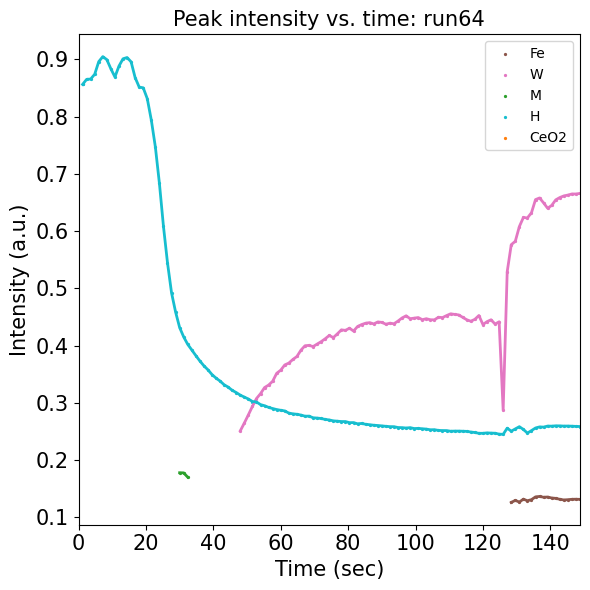

"\nthisfs = 15\n\n#total_I_t = y_fe + y_w + y_m + y_h\nimport array\nfe_array = array.array('f', y_fe)\nw_array = array.array('f', y_w)\nm_array = array.array('f', y_m)\nh_array = array.array('f', y_h)\ntotal_I_t = fe_array + w_array + m_array + h_array\nprint('total_I_t = ', total_I_t)\n#A = 1/total_I_t #normalization factor\nA = [1 / i for i in total_I_t]\nprint('A = ', A)\n\nfig, axx = plt.subplots(figsize=(6,6), tight_layout=True)\naxx.set_xlim(0, 124*frame_length)\naxx.scatter(x_new, np.multiply(A,y_fe), color = lincol_fe, marker='.', s=markersz, label = 'Fe')\n#axx.plot(x_new, y_fe, linewidth = lw, color = lincol_fe)\naxx.scatter(x_new, np.multiply(A,y_w), color = lincol_w, marker='.', s=markersz, label = 'W')\n#axx.plot(x_new, y_w, linewidth = lw, color = lincol_w)\naxx.scatter(x_new, np.multiply(A,y_m), color = lincol_m, marker='.', s=markersz, label = 'M')\n#axx.plot(x_new, y_m, linewidth = lw, color = lincol_m)\naxx.scatter(x_new, np.multiply(A,y_h), color = lincol_h, marker=

In [ ]:
#@title In-situ XRD results on the same time scale

############################## phase analysis vs time ############################
for run in ['run64']:
    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    if get_timestamps: ####### grab ntimestamps curves (equally spacing in time)
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]


    ################ plotting selected timestamps and finding peaks
    find_peak_outputs = []
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        '''
        print()
        print('Loading file', filename)
        '''
        ##print('Scan # ', timestamp_num)
        rawdata = np.loadtxt(filename)
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data


        if timestamp == 'primary-1':
          print('This is the first file')
          #I0 = I
          I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
          I_treated = I0/I0.max()
        # '''
        # if timestamp == 'primary-1': #for run 52, need to have 125 files
        #   print('This is the first file')
        #   I_treated = I/I.max()
        # elif timestamp == 'primary-2': #for run 52, need to have 125 files
        #   print('This is the second file')
        #   #I0 = I
        #   I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
        #   I_treated = I0/I0.max()
        # '''
        else:
          #print('not the first file...')
          #I_treated = I/I0
          I_treated = I/I0.max()

        ####### find peaks ######################################################
        #scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

        I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
        I_w = I_treated[I_w_low:I_w_up]
        I_m = I_treated[I_m_low:I_m_up]
        I_h = I_treated[I_h_low:I_h_up]
        I_ceo2 = I_treated[I_ceo2_low:I_ceo2_up]

        #num_phases = ['fe', 'w', 'm', 'h']
        num_phases = ['fe', 'w', 'm', 'h', 'ceo2']
        for iii in num_phases: #repeat this process for each phase
          #print('iii = ', iii)
          ############for iron#############################
          if iii == num_phases[0]: #iron
            peaks, properties = find_peaks(I_fe, prominence_fe)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
              val1_fe = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
              val2_fe = I_treated[(I_fe_low + peaks)][0]
              ##print('Fe peak is located at q = ', val1_fe, ' with I_treated = ', val2_fe)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_fe = float('nan')
              #val2_fe = 0 #set intensity equal to zero if no peak is found
              val2_fe = float('nan')

          ############for hematite#############################
          if iii == num_phases[3]: #hematite
            peaks, properties = find_peaks(I_h, prominence_h)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_h = q[(I_h_low + peaks)][0]
              val2_h = I_treated[(I_h_low + peaks)][0]
              ##print('H peak is located at q = ', val1_h, ' with I_treated = ', val2_h)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_h = float('nan')
              #val2_h = 0
              val2_h = float('nan')

          ############for wustite#############################
          if iii == num_phases[1]: #wustite
            peaks, properties = find_peaks(I_w, prominence_w)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_w = q[(I_w_low + peaks)][0]
              val2_w = I_treated[(I_w_low + peaks)][0]
              ##print('W peak is located at q = ', val1_w, ' with I_treated = ', val2_w)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_w = float('nan')
              #val2_w = 0
              val2_w = float('nan')

          ############for magnetite#############################
          if iii == num_phases[2]: #magnetite
            peaks, properties = find_peaks(I_m, prominence_m)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_m = q[(I_m_low + peaks)][0]
              val2_m = I_treated[(I_m_low + peaks)][0]
              ##print('M peak is located at q = ', val1_m, ' with I_treated = ', val2_m)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_m = float('nan')
              #val2_m = 0
              val2_m = float('nan')

          ############for ceo2 #############################
          if iii == num_phases[4]: #ceo2
            peaks, properties = find_peaks(I_ceo2, prominence_ceo2)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_ceo2 = q[(I_ceo2_low + peaks)][0]
              val2_ceo2 = I_treated[(I_ceo2_low + peaks)][0]
              ##print('ceo2 peak is located at q = ', val1_ceo2, ' with I_treated = ', val2_ceo2)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_ceo2 = float('nan')
              #val2_ceo2 = 0
              val2_ceo2 = float('nan')


        #set the values here for this one timestamp
        item = {'Scan#': timestamp_num,
                'Fe': [val1_fe, val2_fe],
                'H': [val1_h, val2_h],
                'W': [val1_w, val2_w],
                'M': [val1_m, val2_m],
                'CeO2': [val1_ceo2, val2_ceo2]
                }
        find_peak_outputs.append(item)
        #print('find_peak_outputs = ', find_peak_outputs)



  ###### plotting results vs time ##################################################
    x = []
    y_fe = []
    y_h = []
    y_w = []
    y_m = []
    y_ceo2 = []
    T_C = []
    '''
    print("find_peak_outputs = ", find_peak_outputs)
    print('timestamps = ', timestamps)
    print('ntimestamps = ', ntimestamps)
    print()
    '''
    for i, timestamp in enumerate(timestamps):
      timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
      #print('timestamp_num = ', timestamp_num)
      index_request = i
      #print('index is =', index_request)
      if index_request > ntimestamps: #once we've gone through the full list of timestamps, break the for loop
        break
      else:
        #print("find_peak_outputs[index_request]['Scan#'] = ", find_peak_outputs[index_request]['Scan#'])
        scan = find_peak_outputs[index_request]['Scan#']
        inten_fe = find_peak_outputs[index_request]['Fe'][1] #second value in the array gives intensity
        inten_h = find_peak_outputs[index_request]['H'][1]
        inten_w = find_peak_outputs[index_request]['W'][1]
        inten_m = find_peak_outputs[index_request]['M'][1]
        inten_ceo2 = find_peak_outputs[index_request]['CeO2'][1]
        x.append(scan)
        y_fe.append(inten_fe)
        y_h.append(inten_h)
        y_w.append(inten_w)
        y_m.append(inten_m)
        y_ceo2.append(inten_ceo2)

        pos_fe = find_peak_outputs[index_request]['Fe'][0] #for rough calculation of temperature
        pos_h = find_peak_outputs[index_request]['H'][0]
        pos_ceo2 = find_peak_outputs[index_request]['CeO2'][0]
        T_C.append(25 + (1000000/11.8)*2*np.pi*(1/pos_ceo2 - 1/2.013)) #(13.5) https://www.sciencedirect.com/science/article/pii/0022459689901370, (11.8) https://www.sciencedirect.com/science/article/pii/S0254058499001091
        '''
        if np.isnan(pos_fe): #then use hematite's value
            #T_C.append(float('nan'))
            #T_C.append(25 + (1000000/14)*2*np.pi*(1/pos_h - 1/2.3135)) #alpha_L,hematite = 14x10-6 /C
            T_C.append(25 + (1000000/11)*2*np.pi*(1/pos_ceo2 - 1/2.013)) #alpha_L,ceo2 = 1.13×10−6 /C: https://ceramics.onlinelibrary.wiley.com/doi/am-pdf/10.1111/jace.16055
        else:
            #T_C.append(25 + (1000000/12.5)*2*np.pi*(1/pos_fe - 1/3.128))
            T_C.append(25 + (1000000/12)*2*np.pi*(1/pos_fe - 1/3.128)) #alpha_L,Fe = 12x10-6 /C
        '''
      #print()
    print()
    print('x = ', x)
    print('y_fe = ', y_fe)
    print('y_h = ', y_h)
    print('y_w = ', y_w)
    print('y_m = ', y_m)
    print('y_ceo2 = ', y_ceo2)
    print('T_C = ', T_C)

    ####plotting peak intensity in terms of time, not scan #:
    x_new = [i * frame_length for i in x]

    thisfs = 15

    fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
    axx.set_xlim(0, 124*frame_length)
    axx.scatter(x_new, y_fe, color = lincol_fe, marker='.', s=markersz, label = 'Fe')
    axx.plot(x_new, y_fe, linewidth = lw, color = lincol_fe)
    axx.scatter(x_new, y_w, color = lincol_w, marker='.', s=markersz, label = 'W')
    axx.plot(x_new, y_w, linewidth = lw, color = lincol_w)
    axx.scatter(x_new, y_m, color = lincol_m, marker='.', s=markersz, label = 'M')
    axx.plot(x_new, y_m, linewidth = lw, color = lincol_m)
    axx.scatter(x_new, y_h, color = lincol_h, marker='.', s=markersz, label = 'H')
    axx.plot(x_new, y_h, linewidth = lw, color = lincol_h)
    axx.scatter(x_new, y_ceo2, color = lincol_ceo2, marker='.', s=markersz, label = 'CeO2')
    axx.plot(x_new, y_ceo2, linewidth = lw, color = lincol_ceo2)

    '''
    # manually mark when the laser turned on, reached max power, and turned off ##
    laserls = 'dotted'
    lasercol = 'tab:gray'
    for vi in laser:
      plt.axvline(x=vi, linestyle=laserls, color=lasercol)
    '''
    plt.legend(loc='upper right')
    # axx.set_xlabel('Scan #', fontsize=thisfs)
    axx.set_xlabel('Time (sec)', fontsize=thisfs)
    axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
    axx.tick_params(axis='x', labelsize=thisfs)
    axx.tick_params(axis='y', labelsize=thisfs)
    plottit = 'Peak intensity vs. time: ' + expname.split('_')[0]
    axx.set_title(plottit, fontsize=thisfs)
    plt.show()
    #be sure to check that the range, prominence, etc still work with a larger dataset of 125 timestamps

############# plotting approximate "phase fraction" ##################
'''
thisfs = 15

#total_I_t = y_fe + y_w + y_m + y_h
import array
fe_array = array.array('f', y_fe)
w_array = array.array('f', y_w)
m_array = array.array('f', y_m)
h_array = array.array('f', y_h)
total_I_t = fe_array + w_array + m_array + h_array
print('total_I_t = ', total_I_t)
#A = 1/total_I_t #normalization factor
A = [1 / i for i in total_I_t]
print('A = ', A)

fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
axx.set_xlim(0, 124*frame_length)
axx.scatter(x_new, np.multiply(A,y_fe), color = lincol_fe, marker='.', s=markersz, label = 'Fe')
#axx.plot(x_new, y_fe, linewidth = lw, color = lincol_fe)
axx.scatter(x_new, np.multiply(A,y_w), color = lincol_w, marker='.', s=markersz, label = 'W')
#axx.plot(x_new, y_w, linewidth = lw, color = lincol_w)
axx.scatter(x_new, np.multiply(A,y_m), color = lincol_m, marker='.', s=markersz, label = 'M')
#axx.plot(x_new, y_m, linewidth = lw, color = lincol_m)
axx.scatter(x_new, np.multiply(A,y_h), color = lincol_h, marker='.', s=markersz, label = 'H')
#axx.plot(x_new, y_h, linewidth = lw, color = lincol_h)
axx.scatter(x_new, np.multiply(A,y_ceo2), color = lincol_ceo2, marker='.', s=markersz, label = 'CeO2')
#axx.plot(x_new, y_ceo2, linewidth = lw, color = lincol_ceo2)


plt.legend(loc='upper right')
# axx.set_xlabel('Scan #', fontsize=thisfs)
axx.set_xlabel('Time (sec)', fontsize=thisfs)
axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
axx.tick_params(axis='x', labelsize=thisfs)
axx.tick_params(axis='y', labelsize=thisfs)
plottit = 'Peak intensity vs. time: ' + expname.split('_')[0]
axx.set_title(plottit, fontsize=thisfs)
plt.show()
'''

/content/drive/Shareddrives/leoradm_group/NSLS-II_202403/laser_programs_and_logs/LOG-Mar.28.2024-11.08.12-run64.csv
1
no its not
no its not
no its not
no its not

recnum =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 1

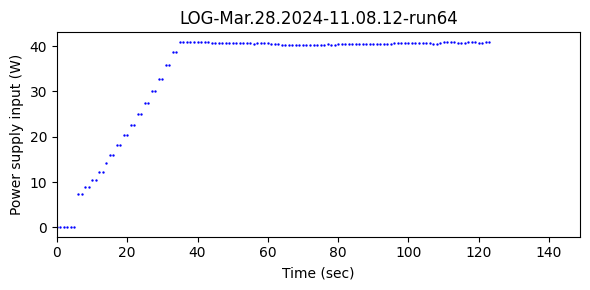

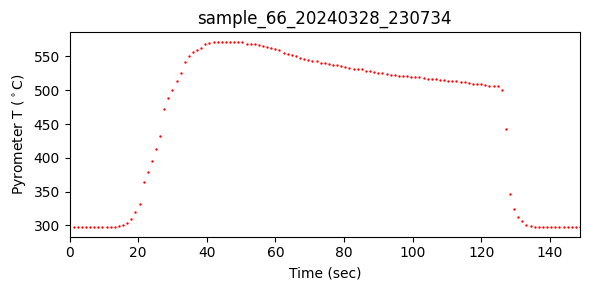

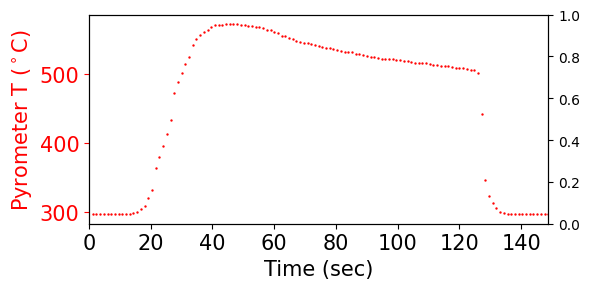

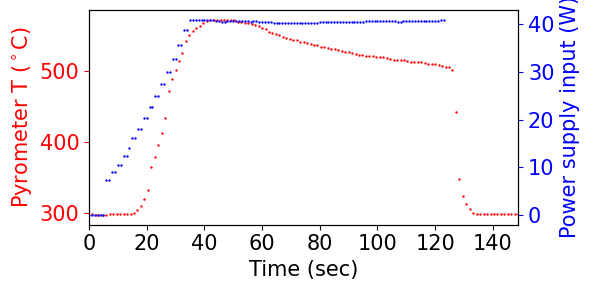

In [ ]:
#@title Laser and temperature data extraction
######################### laser log ###########################################
path = os.path.join(userdir, 'laser_programs_and_logs')
fp = os.path.join(path, fn_laser + '.csv')
print(fp)

laser_log_data = []
with open(fp, mode = 'r')as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        #print(lines)
        laser_log_data.append(lines) #extract data from the file for python treatment

st = laser_log_data[2]['FileType:PSCS_Data_Log'].split(':')[-1]
st = st.replace('S', '') #sampling time
print(st)

lt = str(laser_log_data[1][None]) #laser log start time
lt = lt.replace("[' 2024", "")
lt = lt.replace(" PM']", "")
lt = lt.translate({ord(i): None for i in " "}) #strip any whitespace from the string
# print(lt)
# print(st)
#print('The log began recording at',lt,'and the sampling time is',st,'sec')


#print()
#print('here are the table headings: ', laser_log_data[3])

recnum = []
volt = []
current = []
count = 0
for lines in laser_log_data:
    if count >= 4:
        recnum.append(int(laser_log_data[count]['FileType:PSCS_Data_Log'].split(':')[-1]))
        volt.append(int(laser_log_data[count][None][0]) / 1000) #in V
        current.append(int(laser_log_data[count][None][1]) / 1000) #in A
    elif count < 4:
        print('no its not')
    count = count + 1
print()
print('recnum = ', recnum)
print('volt = ', volt)
print('current = ', current)

power = np.multiply(volt, current)

a = recnum[index_start:index_start+124] #shifting the time data to match t=0 with the in-situ XRD
x_axis_laser = [x - recnum[index_start] for x in a] #shift to match t=0 with XRD
x_axis_laser = [i * t_laser_sampling for i in x_axis_laser] #multiply by sampling rate to get real time
y_axis_laser = power[index_start:index_start+124]
print('x_axis = ', x_axis_laser)


figsize = (6, 3)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)


#txt = 'The log began recording at ' + lt + ' with ' + st +' sec sampling \n t = 0 in the plot above is '+ t_xrd_start
#plt.scatter(recnum, power, marker = '.', s = markersz)
plt.scatter(x_axis_laser, y_axis_laser, marker = '.', s = markersz, c = 'b')
plt.ylabel("Power supply input (W)")
# plt.xlabel("Rec#")
plt.xlabel("Time (sec)")
plt.title(fn_laser)
#plt.figtext(0.5, -.125, txt, wrap=True, horizontalalignment='center', fontsize=10)
ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
ax.set_xlim(0, (ntimestamps-1)*frame_length)
##################################################################################

#################### Plotting the pyrometer data: T vs scan #, 5/16/24 ##########
path = os.path.join(userdir, 'tiff_base')
fp = os.path.join(path, fn_pyrom + '.xlsx')
print(fp)
pyrom_data = pd.read_excel(fp)
x_axis_pyrom = pyrom_data['seq_num']
x_axis_pyrom_new = [i * frame_length for i in x_axis_pyrom]
y_axis_pyrom = pyrom_data['eurotherm_temperature']

figsize = (6, 3)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
#ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
#ax.set_xticks([0, 100, 200, 300, 400, 500, 600])
ax.set_xlim(0, (ntimestamps-1)*frame_length)
laserls = 'dotted'
lasercol = 'tab:gray'

#plt.scatter(x_axis, y_axis)
plt.scatter(x_axis_pyrom_new, y_axis_pyrom, marker = '.', s = markersz, c = 'r')
plt.ylabel("Pyrometer T ($^\circ$C)")
#plt.xlabel("Scan #")
plt.xlabel("Time (sec)")
plt.title(fn_pyrom)

plt.show()

##################################################################################
figsize = (6, 3)
fs = 18
########### combined plot pyrometer vs calculation ####################
'''
fig, axxx = plt.subplots(figsize=(6,3), tight_layout=True)
axxx.set_xlim(0, (ntimestamps-1)*frame_length)
axxx.scatter(x_new, T_C, marker='.', s=markersz)
axxx.set_xlabel('Time (sec)', fontsize=thisfs)
axxx.set_ylabel('Calculated T ($^\circ$C)', fontsize=thisfs)
'''
fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)
ax2 = ax1.twinx()
ax1.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
ax1.set_xlim(0, (ntimestamps-1)*frame_length)

ax1.scatter(x_axis_pyrom_new, y_axis_pyrom, marker = '.', s = markersz, c = 'r')
ax1.set_xlabel("Time (sec)", fontsize=thisfs)
ax1.tick_params(axis='x', labelsize=thisfs)
ax1.set_ylabel("Pyrometer T ($^\circ$C)", fontsize=thisfs, color='r')
ax1.tick_params(axis='y', colors='red', labelsize=thisfs)
######## calculated T #########
'''
ax2.scatter(x_new, T_C, marker = '.', s = markersz, c = 'g')
ax2.set_ylabel('Calculated T ($^\circ$C)', fontsize=thisfs, color='g')
ax2.tick_params(axis='y', colors='green', labelsize=thisfs)
'''

plt.show()

########### combined plot pyrometer vs laser ####################
fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)
ax2 = ax1.twinx()
ax1.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
ax1.set_xlim(0, (ntimestamps-1)*frame_length)

ax1.scatter(x_axis_pyrom_new, y_axis_pyrom, marker = '.', s = markersz, c = 'r')
ax2.scatter(x_axis_laser, y_axis_laser, marker = '.', s = markersz, c = 'b')
ax1.set_xlabel("Time (sec)", fontsize=thisfs)
ax1.tick_params(axis='x', labelsize=thisfs)
ax1.set_ylabel("Pyrometer T ($^\circ$C)", fontsize=thisfs, color='r')
ax1.tick_params(axis='y', colors='red', labelsize=thisfs)
ax2.set_ylabel('Power supply input (W)', fontsize=thisfs, color='b')
ax2.tick_params(axis='y', colors='blue', labelsize=thisfs)

plt.show()

In [ ]:
#@title Temperature and laser plots

######################### laser log ###########################################
path = os.path.join(userdir, 'laser_programs_and_logs')
fp = os.path.join(path, fn_laser + '.csv')
print(fp)

laser_log_data = []
with open(fp, mode = 'r')as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        #print(lines)
        laser_log_data.append(lines) #extract data from the file for python treatment

st = laser_log_data[2]['FileType:PSCS_Data_Log'].split(':')[-1]
st = st.replace('S', '') #sampling time
print(st)

lt = str(laser_log_data[1][None]) #laser log start time
lt = lt.replace("[' 2024", "")
lt = lt.replace(" PM']", "")
lt = lt.translate({ord(i): None for i in " "}) #strip any whitespace from the string
# print(lt)
# print(st)
#print('The log began recording at',lt,'and the sampling time is',st,'sec')


#print()
#print('here are the table headings: ', laser_log_data[3])

recnum = []
volt = []
current = []
count = 0
for lines in laser_log_data:
    if count >= 4:
        recnum.append(int(laser_log_data[count]['FileType:PSCS_Data_Log'].split(':')[-1]))
        volt.append(int(laser_log_data[count][None][0]) / 1000) #in V
        current.append(int(laser_log_data[count][None][1]) / 1000) #in A
    elif count < 4:
        print('no its not')
    count = count + 1
print()
print('recnum = ', recnum)
print('volt = ', volt)
print('current = ', current)

power = np.multiply(volt, current)

a = recnum[index_start:index_start+124] #shifting the time data to match t=0 with the in-situ XRD
x_axis_laser = [x - recnum[index_start] for x in a] #shift to match t=0 with XRD
x_axis_laser = [i * t_laser_sampling for i in x_axis_laser] #multiply by sampling rate to get real time
y_axis_laser = power[index_start:index_start+124]
print('x_axis = ', x_axis_laser)


figsize = (6, 3)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)


#txt = 'The log began recording at ' + lt + ' with ' + st +' sec sampling \n t = 0 in the plot above is '+ t_xrd_start
#plt.scatter(recnum, power, marker = '.', s = markersz)
plt.scatter(x_axis_laser, y_axis_laser, marker = '.', s = markersz, c = 'b')
plt.ylabel("Power supply input (W)")
# plt.xlabel("Rec#")
plt.xlabel("Time (sec)")
plt.title(fn_laser)
#plt.figtext(0.5, -.125, txt, wrap=True, horizontalalignment='center', fontsize=10)
ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
ax.set_xlim(0, (ntimestamps-1)*frame_length)
##################################################################################

#################### Plotting the pyrometer data: T vs scan #, 5/16/24 ##########
path = os.path.join(userdir, 'tiff_base')
fp = os.path.join(path, fn_pyrom + '.xlsx')
print(fp)
pyrom_data = pd.read_excel(fp)
x_axis_pyrom = pyrom_data['seq_num']
x_axis_pyrom_new = [i * frame_length for i in x_axis_pyrom]
y_axis_pyrom = pyrom_data['eurotherm_temperature']

figsize = (6, 3)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
#ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
#ax.set_xticks([0, 100, 200, 300, 400, 500, 600])
ax.set_xlim(0, (ntimestamps-1)*frame_length)
laserls = 'dotted'
lasercol = 'tab:gray'

#plt.scatter(x_axis, y_axis)
plt.scatter(x_axis_pyrom_new, y_axis_pyrom, marker = '.', s = markersz, c = 'r')
plt.ylabel("Pyrometer T ($^\circ$C)")
#plt.xlabel("Scan #")
plt.xlabel("Time (sec)")
plt.title(fn_pyrom)

plt.show()

##################################################################################

# OLD

In [ ]:
#@title IGNORE (OUTDATED) Tracking peak position with time (multiple phases)
for run in ['run26']:
    ntimestamps = 125 ##########change later

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    ################ plotting selected timestamps and finding peaks
    find_peak_outputs = []
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        '''
        print()
        print('Loading file', filename)
        '''
        ##print('Scan # ', timestamp_num)
        rawdata = np.loadtxt(filename)
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        #I = I - I[2350]
        '''
        #I = I + iv * 300
        #I = I + iv * 100 #iv is basically the index number for the scan. this makes a waterfall plot
        # I = I/I.max() + 0.25 * iv
        '''

        if timestamp == 'primary-1':
          print('This is the first file')
          #I0 = I
          I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
          I_treated = I0/I0.max()
        # '''
        # if timestamp == 'primary-1': #for run 52, need to have 125 files
        #   print('This is the first file')
        #   I_treated = I/I.max()
        # elif timestamp == 'primary-2': #for run 52, need to have 125 files
        #   print('This is the second file')
        #   #I0 = I
        #   I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
        #   I_treated = I0/I0.max()
        # '''
        else:
          #print('not the first file...')
          #I_treated = I/I0
          I_treated = I/I0.max()
          #I = I + iv * 5 #only for visualizing, not for peak finding

        ####### find peaks ######################################################
        #scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
        I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
        I_w = I_treated[I_w_low:I_w_up]
        I_m = I_treated[I_m_low:I_m_up]
        I_h = I_treated[I_h_low:I_h_up]

        num_phases = ['fe', 'w', 'm', 'h']
        for iii in num_phases: #repeat this process for each phase
          #print('iii = ', iii)
          ############for iron#############################
          if iii == num_phases[0]: #iron
            peaks, properties = find_peaks(I_fe, prominence_fe)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
              val1_fe = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
              val2_fe = I_treated[(I_fe_low + peaks)][0]
              ##print('Fe peak is located at q = ', val1_fe, ' with I_treated = ', val2_fe)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_fe = float('nan')
              #val2_fe = 0 #set intensity equal to zero if no peak is found
              val2_fe = float('nan')

          ############for hematite#############################
          if iii == num_phases[3]: #hematite
            peaks, properties = find_peaks(I_h, prominence_h)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_h = q[(I_h_low + peaks)][0]
              val2_h = I_treated[(I_h_low + peaks)][0]
              ##print('H peak is located at q = ', val1_h, ' with I_treated = ', val2_h)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_h = float('nan')
              #val2_h = 0
              val2_h = float('nan')

          ############for wustite#############################
          if iii == num_phases[1]: #wustite
            peaks, properties = find_peaks(I_w, prominence_w)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_w = q[(I_w_low + peaks)][0]
              val2_w = I_treated[(I_w_low + peaks)][0]
              ##print('W peak is located at q = ', val1_w, ' with I_treated = ', val2_w)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_w = float('nan')
              #val2_w = 0
              val2_w = float('nan')

          ############for magnetite#############################
          if iii == num_phases[2]: #magnetite
            peaks, properties = find_peaks(I_m, prominence_m)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_m = q[(I_m_low + peaks)][0]
              val2_m = I_treated[(I_m_low + peaks)][0]
              ##print('M peak is located at q = ', val1_m, ' with I_treated = ', val2_m)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_m = float('nan')
              #val2_m = 0
              val2_m = float('nan')


        #set the values here for this one timestamp
        item = {'Scan#': timestamp_num,
                'Fe': [val1_fe, val2_fe],
                'H': [val1_h, val2_h],
                'W': [val1_w, val2_w],
                'M': [val1_m, val2_m]
                }
        find_peak_outputs.append(item)
        #print('find_peak_outputs = ', find_peak_outputs)
    #
        #ok, now plot the result of find_peaks for this run, to make sure  ################
        #would like to create a movie for each frame, displaying in the output window but without saving the movie
        ################Yifan pls help with implementing this

  ###### plot peak intensity vs time ##################################################
    x = []
    y_fe = []
    y_h = []
    y_w = []
    y_m = []
    '''
    print("find_peak_outputs = ", find_peak_outputs)
    print('timestamps = ', timestamps)
    print('ntimestamps = ', ntimestamps)
    print()
    '''
    for i, timestamp in enumerate(timestamps):
      timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
      #print('timestamp_num = ', timestamp_num)
      index_request = i
      #print('index is =', index_request)
      if index_request > ntimestamps: #once we've gone through the full list of timestamps, break the for loop
        break
      else:
        #print("find_peak_outputs[index_request]['Scan#'] = ", find_peak_outputs[index_request]['Scan#'])
        scan = find_peak_outputs[index_request]['Scan#']
        inten_fe = find_peak_outputs[index_request]['Fe'][1] #second value in the array gives intensity
        inten_h = find_peak_outputs[index_request]['H'][1]
        inten_w = find_peak_outputs[index_request]['W'][1]
        inten_m = find_peak_outputs[index_request]['M'][1]
        x.append(scan)
        y_fe.append(inten_fe)
        y_h.append(inten_h)
        y_w.append(inten_w)
        y_m.append(inten_m)
      #print()
    print('x = ', x)
    print('y_fe = ', y_fe)
    print('y_h = ', y_h)
    print('y_w = ', y_w)
    print('y_m = ', y_m)

    ####to plot in terms of time, not scan #:
    #frame_rate = 1.2 #1.2 sec/frame
    frame_rate = 5 #1.2 sec/frame
    x_new = [i * frame_rate for i in x]

    thisfs = 15
    markersz = 7
    laserls = 'dotted'
    lasercol = 'tab:gray'
    fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
    axx.set_xlim(0, 124*1.2)
    axx.scatter(x_new, y_fe, color = lincol_fe, marker='.', s=markersz, label = 'Fe')
    axx.plot(x_new, y_fe, linewidth = lw, color = lincol_fe)
    axx.scatter(x_new, y_w, color = lincol_w, marker='.', s=markersz, label = 'W')
    axx.plot(x_new, y_w, linewidth = lw, color = lincol_w)
    axx.scatter(x_new, y_m, color = lincol_m, marker='.', s=markersz, label = 'M')
    axx.plot(x_new, y_m, linewidth = lw, color = lincol_m)
    axx.scatter(x_new, y_h, color = lincol_h, marker='.', s=markersz, label = 'H')
    axx.plot(x_new, y_h, linewidth = lw, color = lincol_h)

    ## manually mark when the laser turned on, reached max power, and turned off ##
    # for vi in laser:
    #   plt.axvline(x=vi, linestyle=laserls, color=lasercol)

    plt.legend(loc='upper right')
    # axx.set_xlabel('Scan #', fontsize=thisfs)
    axx.set_xlabel('Time (sec)', fontsize=thisfs)
    axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
    plottit = 'Peak intensity vs. time: ' + expname.split('_')[0]
    axx.set_title(plottit, fontsize=thisfs)
    plt.show()
    #be sure to check that the range, prominence, etc still work with a larger dataset of 125 timestamps

In [ ]:
#@title Tracking peak position with time (one phase)
from scipy.signal import find_peaks
for run in ['run51']:
    ntimestamps = 5 ##########change later

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    ################# plotting setting
    #figsize = (12, 6)
    figsize = (10, 6)
    fs = 18
    fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!

    num_of_lines = len(timestamps)
    lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
    counting = 0
    ################ plotting selected timestamps and finding peaks
    find_peak_outputs = []
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        print()
        print('Loading file', filename)
        print('Scan # ', timestamp_num)
        rawdata = np.loadtxt(filename)
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        #I = I - I[2350]
        '''
        #I = I + iv * 300
        #I = I + iv * 100 #iv is basically the index number for the scan. this makes a waterfall plot
        # I = I/I.max() + 0.25 * iv
        '''

        if timestamp == 'primary-1':
          print('This is the first file')
          #I0 = I
          I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
          I_treated = I0/I0.max()
        else:
          #print('not the first file...')
          #I_treated = I/I0
          I_treated = I/I0.max()
          #I = I + iv * 5 #only for visualizing, not for peak finding

        ###### plot waterfall data ########################################
        c=next(lincol_gradient)
        #ax.plot(q, I, color = c, linewidth = lw)
        ax.plot(q, I_treated, color = c, linewidth = lw)
        ax.text(q[-1], I[-1], timestamp, ha='right', va='bottom')

        counting = counting + 1

        ####### find peaks ######################################################
        #find where the peak range should be, for given input index
        plt.axvline(x=q[880], linestyle='solid', linewidth = .1, color=lincol_fe)
        plt.axvline(x=q[915], linestyle='solid', linewidth = .1, color=lincol_fe)
        plt.axvline(x=q[1165], linestyle='solid', linewidth = .1, color=lincol_w)
        plt.axvline(x=q[1200], linestyle='solid', linewidth = .1, color=lincol_w)
        plt.axvline(x=q[590], linestyle='solid', linewidth = .1, color=lincol_m)
        plt.axvline(x=q[625], linestyle='solid', linewidth = .1, color=lincol_m)
        plt.axvline(x=q[660], linestyle='solid', linewidth = .1, color=lincol_h)
        plt.axvline(x=q[680], linestyle='solid', linewidth = .1, color=lincol_h)

        #find peaks
        #scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

        #range and prominence for peak finding
        I_fe_low = 880
        I_fe_up = 915
        #prominence_fe = 1.5
        #prominence_fe = .1
        prominence_fe = .075
        I_w_low = 1165
        I_w_up = 1200
        I_m_low = 590
        I_m_up = 625
        I_h_low = 660
        I_h_up = 680
        prominence_h = .075

        I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
        I_w = I_treated[I_w_low:I_w_up]
        I_m = I_treated[I_m_low:I_m_up]
        I_h = I_treated[I_h_low:I_h_up]


        peaks, properties = find_peaks(I_fe, prominence_fe)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
          val1 = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
          val2 = I_treated[(I_fe_low + peaks)][0]
          print('Fe peak is located at q = ', val1, ' with I_treated = ', val2)
          item = {
          'Scan#': timestamp_num,
          'Fe': [val1, val2]
          }
          find_peak_outputs.append(item)

        else:
          print('List is empty. No peaks found in the specified range')
          item = {
          'Scan#': timestamp_num,
          'Fe': [float('nan'), 0] #, #set intensity equal to zero if no peak is found
          }
          find_peak_outputs.append(item)
        #print('find_peak_outputs = ', find_peak_outputs)

    ######### load multiple reference files, Yifan, 2024/4/12
    ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
    color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
    ref_shift_y = -1
    for i_phase, ref_phase in enumerate(ref_phases):
        reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
        refdata = np.loadtxt(reffile)
        q_ref = refdata[:, 0]
        I_ref = refdata[:, 1]
        I_ref = I_ref - I_ref.min() #"baselining" the data
        sensitivity = 500 #the larger the value, the more prominent the peaks
        #I_ref = I_ref/(I_ref.max()/sensitivity)  + ref_shift_y*(i_phase + 1) -200
        I_ref = I_ref/(I0.max())  + ref_shift_y*(i_phase + 1) -5
        ax.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])


    xlim_left, xlim_right = -0.25, 10.5 #for q
    ax.set_xlim(xlim_left, xlim_right)
    ######## put the legend outside of the box, Yifan, 20240422 ############
    # ax.legend(loc='lower right')
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    ########################################################################

    ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
    ax.set_ylabel(r'$I$', fontsize=fs)
    ax.set_title(expname, fontsize=fs)
    ax.tick_params(labelsize=fs)
    #ax.set_yticklabels([]) #turns off tick labels for vertical axis

################# plot vertical lines for the reference phase peaks

    for i_vert_line in ref_q_fe: #plot the vertical lines
        plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_fe)

    for i_vert_line in ref_q_w:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_w)

    for i_vert_line in ref_q_m:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_m)

    for i_vert_line in ref_q_h:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_h)

 ########## save settings
    if response == "y":
      print("Saving the file...!")
      fname_typ = 'wf_'+ xrd_type + '_' + expname + '.png' #wf = waterfall
      save_loc = os.path.join(userdir, 'userAnalysis' + '/' + 'waterfallPlots'+ '/')
      if not os.path.isdir(save_loc):
          os.makedirs(save_loc)
      plt.savefig(save_loc + fname_typ)
    elif response == "n":
      print()
      print("Showing the plot without saving...")
      plt.show()
    else:
      print()
      print("Please enter yes or no.")

  ######plot the time data
    x = []
    y = []
    '''
    print("find_peak_outputs = ", find_peak_outputs)
    print('timestamps = ', timestamps)
    print('ntimestamps = ', ntimestamps)
    print()
    '''
    for i, timestamp in enumerate(timestamps):
      timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
      #print('timestamp_num = ', timestamp_num)
      index_request = i
      #print('index is =', index_request)
      if index_request > ntimestamps: #once we've gone through the full list of timestamps, break the for loop
        break
      else:
        #print("find_peak_outputs[index_request]['Scan#'] = ", find_peak_outputs[index_request]['Scan#'])
        scan = find_peak_outputs[index_request]['Scan#']
        inten = find_peak_outputs[index_request]['Fe'][1] #second value in the array gives intensity
        x.append(scan)
        y.append(inten)
      #print()
    print('x = ', x)
    print('y = ', y)

    thisfs = 15
    fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
    axx.scatter(x, y, color = lincol_fe, marker='.', s=5)
    axx.plot(x, y, linewidth = lw, color = lincol_fe)
    axx.set_xlabel('Scan #', fontsize=thisfs)
    axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
    plottit = 'Fe formation with time: ' + expname.split('_')[0]
    axx.set_title(plottit, fontsize=thisfs)
    plt.show()
      #check that the range, prominence, etc still work with a larger dataset of 125 timestamps